In [1]:
import matplotlib.pyplot as plt
import numpy as np
from LogGabor import LogGabor
import torch
from torchvision import datasets, transforms
import os
import noise

### MNIST_128

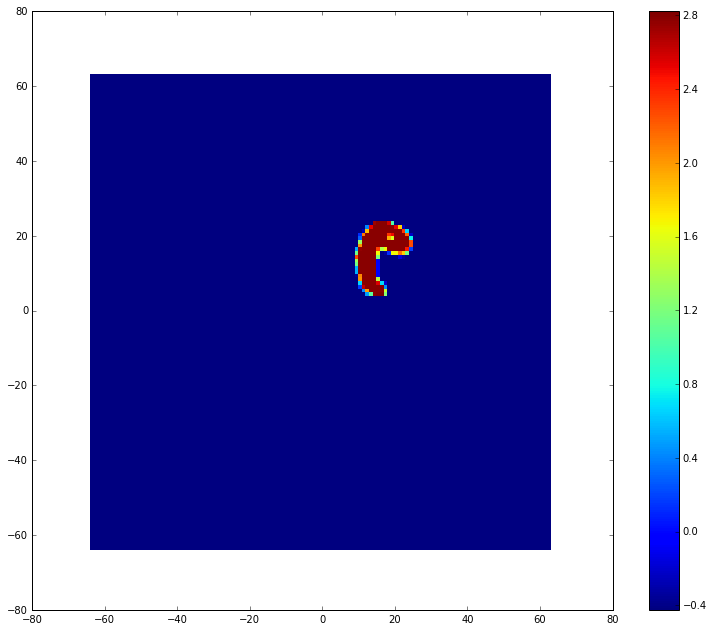

In [2]:
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=False,    #def the dataset as training data 
                   download=True, #download if dataset not present on disk
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
                   batch_size=1, 
                   shuffle=True)

N_pic = 128
center = (128-28)//2
i_offset, j_offset = 15, 15

for batch_idx, (data, target) in enumerate(data_loader):
    data_128 = data.min() * np.ones((128,128))
    data_128[(center+i_offset):(center+28+i_offset),(center+j_offset):(center+28+j_offset)] = data

    fig, ax = plt.subplots(figsize=(13, 10.725))
    cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), data_128)
    fig.colorbar(cmap)
    break

### Bruit perlin

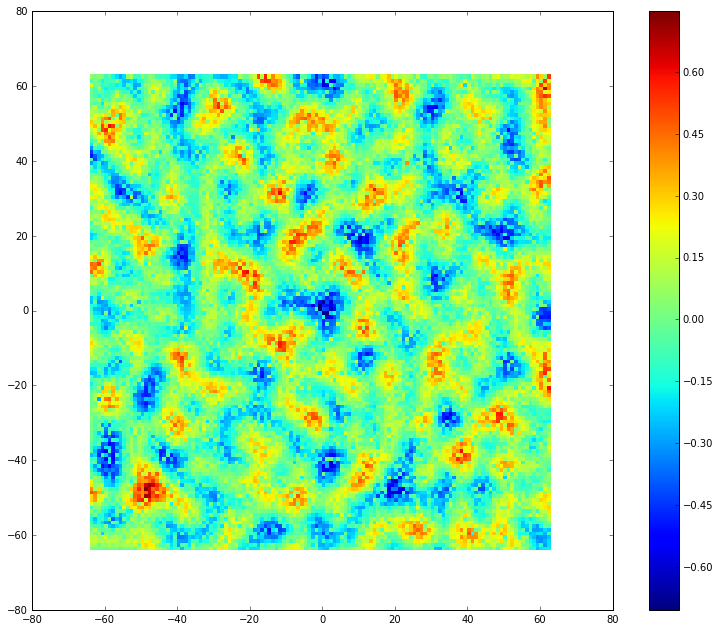

In [8]:
import noise

def randomized_perlin_noise(shape=(128,128), scale=10, octaves=6, persistence=0.5, lacunarity=2.0, base=0):
    noise_vector = np.zeros(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            noise_vector[i][j] = noise.pnoise2(i/scale,
                                        j/scale,
                                        octaves=int(octaves * abs(np.random.randn()))+1,
                                        persistence=persistence * abs(np.random.randn()),
                                        lacunarity=lacunarity * abs(np.random.randn()),
                                        repeatx=shape[0], 
                                        repeaty=shape[1], 
                                        base=base)           

    return noise_vector

fig, ax = plt.subplots(figsize=(13, 10.725))
cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), randomized_perlin_noise())
fig.colorbar(cmap)

### Filtre LogPol classique

In [3]:
rho = 1.61803
#1 / phi **(N_scale - np.arange(N_scale)), 1 / 2 **(N_scale - np.arange(N_scale))

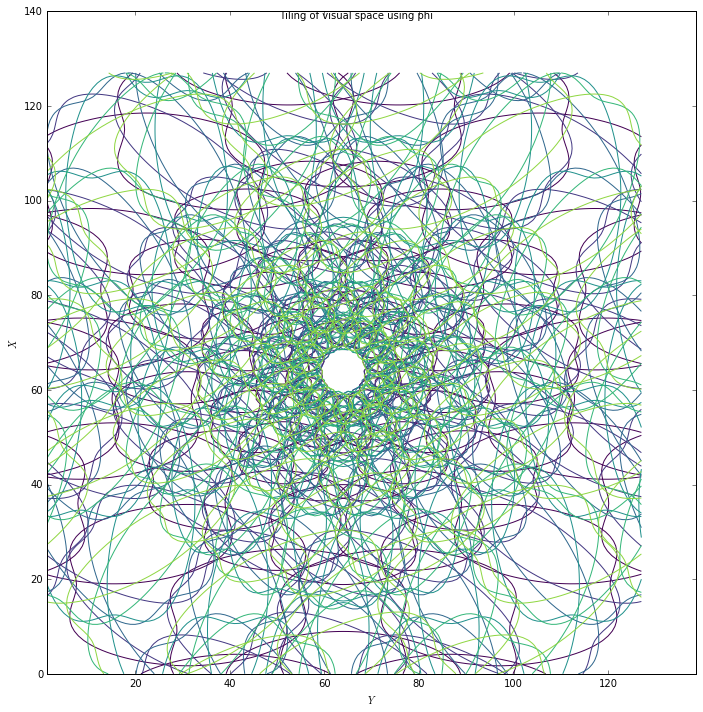

In [4]:
FIG_WIDTH = 10
N_X, N_Y = 128, 128
N_theta, N_orient, N_scale, N_phase = 6, 15, 5, 2
phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))

parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
lg = LogGabor(parameterfile)
lg.set_size((N_X, N_Y))
params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
phase = np.pi/4
edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))

for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            ecc =  (1 / rho) **(N_scale - i_scale)
            r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
            sf_0 = 0.5 * 0.03 / ecc
            x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
            y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
            for i_phase in range(N_phase):
                params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                phase = i_phase * np.pi/2
                phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_theta in range(N_theta):
    for i_orient in range(N_orient):
        for i_scale in range(N_scale):
            env = np.sqrt(phi[i_theta, i_orient, i_scale, 0, :]**2 + phi[i_theta, i_orient, i_scale, 1, :]**2).reshape((N_X, N_Y))
            ax.contour(env, levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using phi')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

### Filtre LogPol classique + image

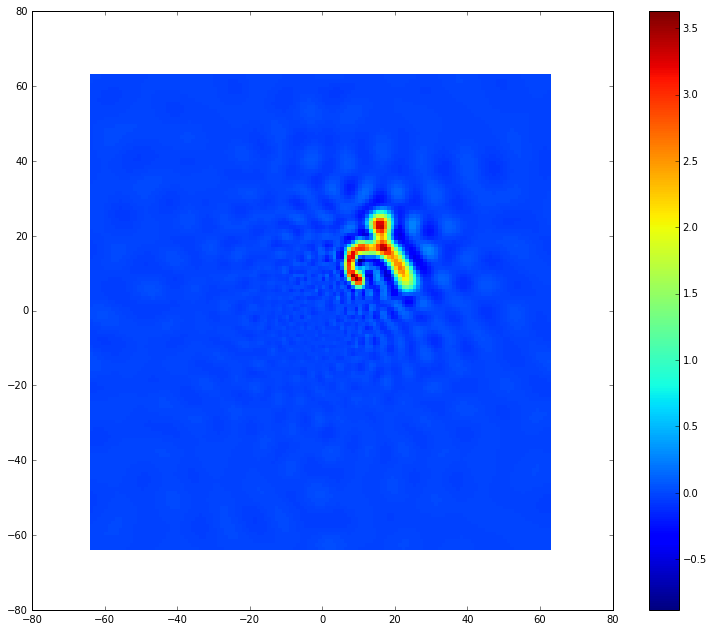

In [5]:
def minmax(value, border):
    value = max(value, -border)
    value = min(value, border)
    return value

data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/tmp/data', 
                   train=False,    #def the dataset as training data 
                   download=True, #download if dataset not present on disk
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))])),
                   batch_size=1, 
                   shuffle=True)

phi_vector = phi.reshape((N_theta*N_orient*N_scale*N_phase, N_X*N_Y))
phi_plus = np.linalg.pinv(phi_vector)

def mnist_128(i_offset, j_offset):
    N_pic = 128
    center = (128-28)//2
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data_128 = data.min() * np.ones((128,128))
        data_128[(center+i_offset):(center+28+i_offset),(center+j_offset):(center+28+j_offset)] = data

        data_LP = phi_vector @ np.ravel(data_128)
        
        image_hat = phi_plus @ data_LP
        fig, ax = plt.subplots(figsize=(13, 10.725))
        cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), image_hat.reshape((N_X, N_Y)))
        fig.colorbar(cmap)
        break
        
mnist_128(15,15)

### Filtre LogPol classique + image + bruit

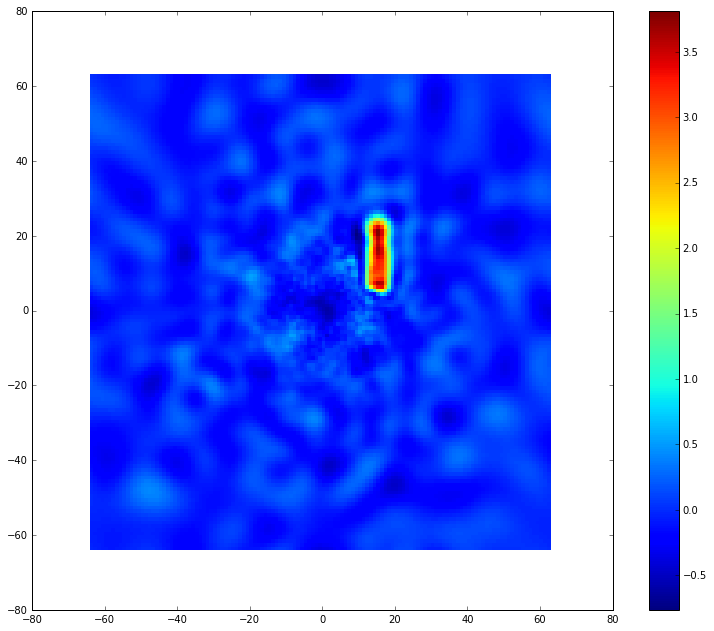

In [9]:
def mnist_128_noised(i_offset, j_offset):
    N_pic = 128
    center = (128-28)//2
    
    for batch_idx, (data, target) in enumerate(data_loader):
        data_128 = data.min() * np.ones((128,128))
        data_128[(center+i_offset):(center+28+i_offset),(center+j_offset):(center+28+j_offset)] = data

        data_LP = phi_vector @ np.ravel(data_128 + randomized_perlin_noise())
        
        image_hat = phi_plus @ data_LP
        fig, ax = plt.subplots(figsize=(13, 10.725))
        cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), image_hat.reshape((N_X, N_Y)))
        fig.colorbar(cmap)
        break
        
mnist_128_noised(15,15)

### Filtre LogPol + orientations moyennées

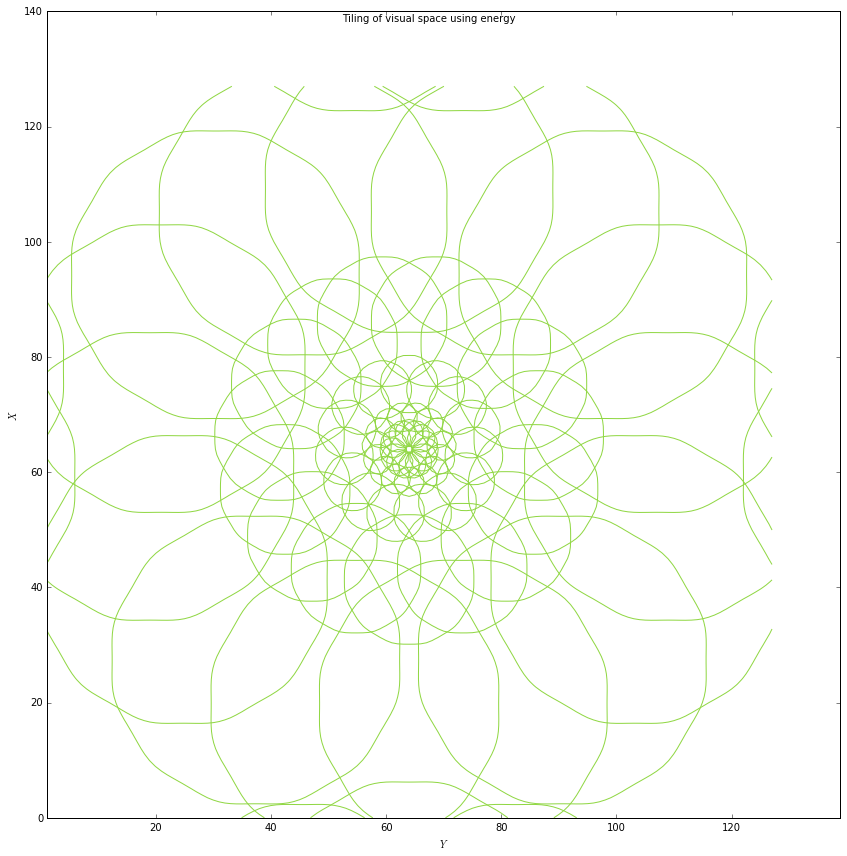

In [6]:
def vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y):
    phi = np.zeros((N_theta, N_orient, N_scale, N_phase, N_X*N_Y))
    parameterfile = 'https://raw.githubusercontent.com/bicv/LogGabor/master/default_param.py'
    lg = LogGabor(parameterfile)
    lg.set_size((N_X, N_Y))
    params= {'sf_0':.1, 'B_sf': lg.pe.B_sf, 'theta':np.pi* 5 / 7., 'B_theta': lg.pe.B_theta}
    phase = np.pi/4
    edge = lg.normalize(lg.invert(lg.loggabor(N_X/3, 3*N_Y/4, **params)*np.exp(-1j*phase)))
    
    for i_theta in range(N_theta):
        for i_orient in range(N_orient):
            for i_scale in range(N_scale):
                ecc =  .5**(N_scale - i_scale)
                r = np.sqrt(N_X**2+N_Y**2) / 2 * ecc # radius
                sf_0 = 0.5 * 0.03 / ecc
                x = N_X/2 + r * np.cos((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)
                y = N_Y/2 + r * np.sin((i_orient+(i_scale % 2)*.5)*np.pi*2 / N_orient)            
                for i_phase in range(N_phase):
                    params= {'sf_0':sf_0, 'B_sf': lg.pe.B_sf, 'theta':i_theta*np.pi/N_theta, 'B_theta': np.pi/N_theta/2}
                    phase = i_phase * np.pi/2
                    phi[i_theta, i_orient, i_scale, i_phase, :] = lg.normalize(lg.invert(lg.loggabor(x, y, **params)*np.exp(-1j*phase))).ravel()            
    return phi

N_theta, N_orient, N_scale, N_phase, N_X, N_Y = 6, 15, 5, 2, 128, 128
phi = vectorization(N_theta, N_orient, N_scale, N_phase, N_X, N_Y)

FIG_WIDTH = 12

energy = (phi**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_orient):
    for i_scale in range(N_scale):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1, colors=[plt.cm.viridis(i_theta/(N_theta))])
fig.suptitle('Tiling of visual space using energy')
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

### Filtre LogPol + orientations moyennées + accuracy

array([ 0.11674661,  0.06236725,  0.06418082,  0.11843362,  0.09940852,
        0.09988284,  0.05533538,  0.09159591,  0.23282619,  0.10204474,
        0.08997496,  0.06322797,  0.11145286,  0.19701786,  0.1038054 ,
        0.08956233,  0.07964105,  0.11148887,  0.11970184,  0.10110157,
        0.09819995,  0.10135432,  0.11206305,  0.10150571,  0.09904767,
        0.11302964,  0.11016427,  0.08813548,  0.09496905,  0.09783941,
        0.12944028,  0.11834331,  0.08220245,  0.09662945,  0.09750796,
        0.1430344 ,  0.12750584,  0.09592843,  0.09734048,  0.09744134,
        0.15003562,  0.12949409,  0.0993567 ,  0.09753678,  0.0974398 ,
        0.15050267,  0.12692468,  0.09974699,  0.09757352,  0.0974378 ,
        0.14644193,  0.12157369,  0.099476  ,  0.09758073,  0.09743997,
        0.1422738 ,  0.11882108,  0.09918102,  0.09759602,  0.09745702,
        0.14149341,  0.1249125 ,  0.09977456,  0.09763397,  0.09746448,
        0.14112413,  0.1263219 ,  0.10430412,  0.09659569,  0.09

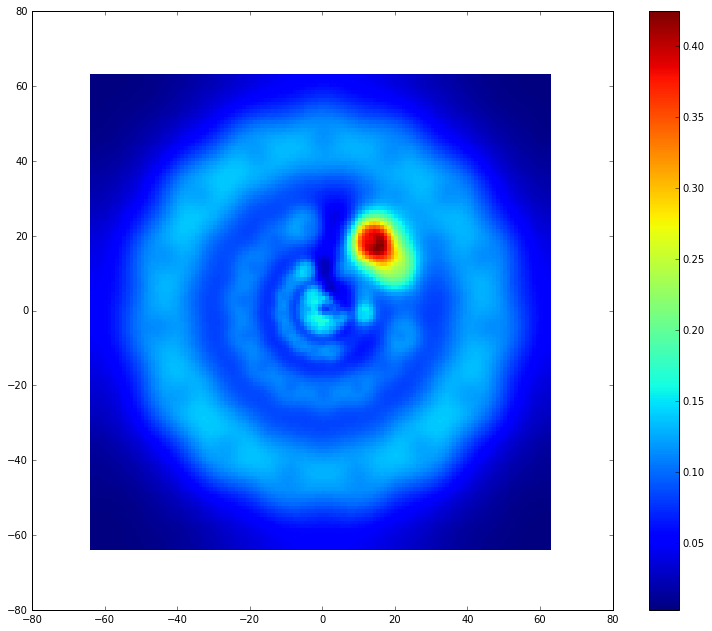

In [7]:
path = "MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy =  np.load(path)

energy_vector = energy.reshape((N_orient*N_scale, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
    
def accuracy_128(i_offset, j_offset, N_pic = 128):
    
    center = (N_pic-55)//2
    
    accuracy_128 = accuracy[0][0] * np.ones((N_pic,N_pic))
    accuracy_128[(center+i_offset):(center+55+i_offset),(center+j_offset):(center+55+j_offset)] = accuracy
    
    accuracy_LP = energy_vector @ np.ravel(accuracy_128)
    
    image_hat = energy_plus @ accuracy_LP   
    fig, ax = plt.subplots(figsize=(13, 10.725))
    cmap = ax.pcolor(np.arange(-N_pic/2, N_pic/2), np.arange(-N_pic/2, N_pic/2), image_hat.reshape((N_X, N_Y)))
    fig.colorbar(cmap)
    
    return accuracy_LP

accuracy_128(15,15)